<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment03/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

### Import

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 551, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 551 (delta 65), reused 25 (delta 20), pack-reused 368 (from 3)
Receiving objects: 100% (551/551), 24.53 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (154/154), done.
PCD  sample_data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

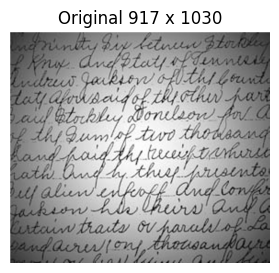

In [31]:
# img_path = '/content/PCD/PCD_Assignment03/images/woman01.jpg'
img_path = '/content/PCD/PCD_Assignment03/images/Script.png'
# img_path = '/content/PCD/PCD_Assignment03/images/grid.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/16x16.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/8x8.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/4x4.jpg'
#
img0 = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
# img = img_as_float(img)

img = copy.deepcopy(img0)
# print(img.shape)
# print(img)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='gray')
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

(917, 1030)
[[255 255 255 ... 255 255 255]
 [255  44  44 ...  66  66  66]
 [255  44  44 ...  66  66  66]
 ...
 [255  65  65 ...  33  34  34]
 [255  65  65 ...  32  33  33]
 [255  65  65 ...  32  33  33]]
[ 17  18  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 2

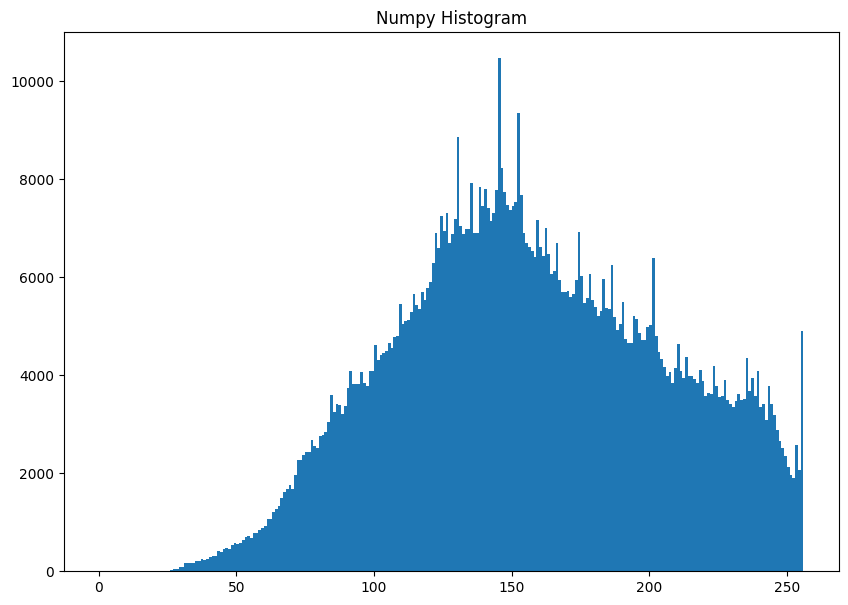

In [32]:
print(img.shape)
print(img)

img1d = img.ravel()
# print(img1d.shape)
# print(img1d)

val, freq = np.unique(img1d, return_counts=True)
# print(val.shape)
# print(freq.shape)
print(val)
print(freq)

bins = np.arange(0, 257)
# print(bins)

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.hist(img1d, bins)
plt.title("Numpy Histogram")
# plt.xticks(np.arange(min(bins), max(bins)+1, 1.0))
# plt.yticks(np.arange(min(freq), max(freq)+1, 1.0))
plt.show()

### **1 Segmentasi**

####  **1.1 Pixel based**



##### Basic Thresholding

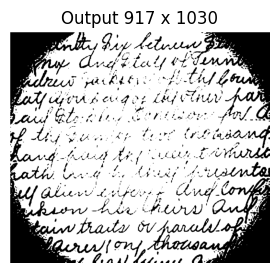

In [33]:
T = 122 #Nilai Threshold


output = np.zeros_like(img)

for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i,j] > T:
      output[i,j] = 255
    else:
      output[i,j] = 0


plt.figure(figsize=(10,3))
plt.imshow(output, cmap='gray')
plt.title(f"Output {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

##### Adaptive Thresholding

In [34]:
#Otsu method
# print(img.shape)
# print(img)

img1d = img.ravel()
# print(img1d.shape)
# print(img1d)

val, freq = np.unique(img1d, return_counts=True)
# print(val.shape)
# print(freq.shape)
print(val)
print(freq)

bins = np.arange(0, 257)
# print(bins)

# # Creating plot
# fig = plt.figure(figsize =(10, 7))
# plt.hist(img1d, bins)
# plt.title("Numpy Histogram")
# # plt.xticks(np.arange(min(bins), max(bins)+1, 1.0))
# # plt.yticks(np.arange(min(freq), max(freq)+1, 1.0))
# plt.show()

[ 17  18  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255]
[    1     1     1     4     3   

##### Probability Thresholding

####  **1.2 Region based**

##### 1.2.1 Region Growing

##### 1.2.2 Watershed / Flood fill

##### 1.2.3 Clustering

#### **1.3 Feature based / Detection**

##### 1.3.1 Sliding Window

### **2 Morphological Process**